# Understand model behavior with Partial Dependence and Individual Condition Expectation Plots

## Introduction

This tutorial demonstrates how to leverage Partial Dependence (PD) and Individual Condition Expectation (ICE) techniques to better describe the average behavior of a classification or regression model in Microsoft Fabric.

Partial Dependence Plots (PDP) and Individual Condition Expectation (ICE) plots are two techniques used in the field of machine learning and interpretability to understand the relationship between a specific feature and the predicted outcome of a model. They are particularly useful when the model developer wants to understand generally how the model depends on individual feature values, overall model behavior and do debugging.

Moreover, to practice responsible AI, it is crucial to understand which features drive your model's predictions. This knowledge can facilitate the creation of transparency notes, facilitate auditing and compliance, help satisfy regulatory requirements, and improve both transparency and accountability.

In this tutorial, you will:

1. Load and process the dataset
2. Train a classification model using the Adult Census Income dataset
3. Determine the feature importance leveraging

    - Partial Dependence Plot (PDP) technique
    - Individual Condition Expectation (ICE) technique

## Step 1: Load and process the dataset

In this tutorial, you will use the [Adult Census Income dataset](https://archive.ics.uci.edu/ml/datasets/Adult). The dataset contains 32,561 rows and 14 columns/features.

Prior to load and process the data, you need to import the required libraries from [PySpark](https://spark.apache.org/docs/latest/api/python/index.html) and [SynapseML](https://microsoft.github.io/SynapseML/).

In [1]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
import pyspark.sql.functions as F
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from synapse.ml.explainers import ICETransformer
import matplotlib.pyplot as plt
from synapse.ml.core.platform import *

StatementMeta(, e2e2ea89-ac4e-4c13-bd3b-97098186c377, 3, Finished, Available)

To disable Microsoft Fabric autologging in a notebook session, call `mlflow.autolog()` and set `disable=True`.

In [2]:
# Set up MLflow for experiment tracking
import mlflow

mlflow.autolog(disable=True)  # Disable MLflow autologging

StatementMeta(, e2e2ea89-ac4e-4c13-bd3b-97098186c377, 4, Finished, Available)

Download a publicly available version of the dataset from the blog storage and then load the data as a spark DataFrame. 

In [3]:
df = spark.read.parquet(
    "wasbs://publicwasb@mmlspark.blob.core.windows.net/AdultCensusIncome.parquet"
)
display(df)

StatementMeta(, e2e2ea89-ac4e-4c13-bd3b-97098186c377, 5, Finished, Available)

SynapseWidget(Synapse.DataFrame, d8e7e38a-cf4e-4198-9291-aafbd4a9bfbe)

## Step 2: Model training

Prior to model training, you need to determine the categorical and numeric features.

In [4]:
categorical_features = [
    "race",
    "workclass",
    "marital-status",
    "education",
    "occupation",
    "relationship",
    "native-country",
    "sex",
]
numeric_features = [
    "age",
    "education-num",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
]

StatementMeta(, e2e2ea89-ac4e-4c13-bd3b-97098186c377, 6, Finished, Available)

Build a pipeline to pre-process the data (indexing categorical features and one-hot encoding them) and then train a Gradient Boosted Tree (GBT) classifier. 

In [5]:
string_indexer_outputs = [feature + "_idx" for feature in categorical_features]
one_hot_encoder_outputs = [feature + "_enc" for feature in categorical_features]

pipeline = Pipeline(
    stages=[
        StringIndexer()
        .setInputCol("income")
        .setOutputCol("label")
        .setStringOrderType("alphabetAsc"),
        StringIndexer()
        .setInputCols(categorical_features)
        .setOutputCols(string_indexer_outputs),
        OneHotEncoder()
        .setInputCols(string_indexer_outputs)
        .setOutputCols(one_hot_encoder_outputs),
        VectorAssembler(
            inputCols=one_hot_encoder_outputs + numeric_features, outputCol="features"
        ),
        GBTClassifier(weightCol="fnlwgt", maxDepth=7, maxIter=100),
    ]
)

model = pipeline.fit(df)

StatementMeta(, e2e2ea89-ac4e-4c13-bd3b-97098186c377, 7, Finished, Available)

Make predictions using the trained GBT classifier. Note that the new DataFrame `data` typically contains the original data from `df` along with the predictions or classifications made by the model.

In [6]:
data = model.transform(df)
display(data.select("income", "probability", "prediction"))

StatementMeta(, e2e2ea89-ac4e-4c13-bd3b-97098186c377, 8, Finished, Available)

SynapseWidget(Synapse.DataFrame, c154cc53-a8b3-4200-bee0-83d74856e48a)

Evaluate the models' performance by calculating the Area under the ROC Curve (AUC-ROC) score.

In [7]:
eval_auc = BinaryClassificationEvaluator(
    labelCol="label", rawPredictionCol="prediction"
)
eval_auc.evaluate(data)

StatementMeta(, e2e2ea89-ac4e-4c13-bd3b-97098186c377, 9, Finished, Available)

0.829785759671695

## Step 3: Determine the feature's importance

### **Partial Dependence Plots**

Partial dependence plots (PDP) show the dependence between the target response and a set of input features of interest, marginalizing over the values of all other input features. It can show whether the relationship between the target response and the input feature is linear, smooth, monotonic, or more complex. This is relevant when you want to have an overall understanding of model behavior, e.g., identifying specific age group has a favorable predictions versus other age groups.

Learn more about [partial dependence plots](https://scikit-learn.org/stable/modules/partial_dependence.html#partial-dependence-plots).

#### Set up the parameters for PDP

To plot PDP you need to set up an instance of `ICETransformer` first and then set the `kind` parameter to `average` and then call the `transform` function. 

For the setup, you need to pass the pre-trained model, specify the target column (e.g., `probability` in this case), and pass the categorical and numeric feature names. Categorical and numeric features can be passed as a list of names. You must specify parameters for the features by passing a list of dictionaries where each dictionary represents one feature. 

For the numerical features a dictionary can look like this:

`{"name": "capital-gain", "numSplits": 20, "rangeMin": 0.0, "rangeMax": 10000.0, "outputColName": "capital-gain_dependance"}`

Where the **required** key-value pair is `name` -  the name of the numeric feature. Next key-values pairs are **optional**: `numSplits` - the number of splits for the value range for the numeric feature, `rangeMin` - specifies the minimum value of the range for the numeric feature, `rangeMax` - specifies the maximum value of the range for the numeric feature, `outputColName` - the name for output column with explanations for the feature.


For the categorical features a dictionary can look like this:

`{"name": "marital-status", "numTopValues": 10, "outputColName": "marital-status_dependance"}`

Where the **required** key-value pair is `name` -  the name of the categorical feature. Next key-values pairs are optional: `numTopValues` - the maximum number of top-occurring values to be included in the categorical feature, `outputColName` - the name for output column with explanations for the feature.

In [8]:
pdp = ICETransformer(
    model=model,
    targetCol="probability",
    kind="average",
    targetClasses=[1],
    categoricalFeatures=categorical_features,
    numericFeatures=numeric_features,
)

StatementMeta(, e2e2ea89-ac4e-4c13-bd3b-97098186c377, 10, Finished, Available)

PDP transformer returns a DataFrame that consists of 1 row and $N$ columns where $N$ refers to the number of features to explain. Each column contains a map between the feature's values and the model's average dependence for that feature value.

In [9]:
output_pdp = pdp.transform(df)
display(output_pdp)

StatementMeta(, e2e2ea89-ac4e-4c13-bd3b-97098186c377, 11, Finished, Available)

SynapseWidget(Synapse.DataFrame, 1d8f2a23-d51d-46e6-b467-93f0484bc222)

#### Visualization of PDPs

In the following, you develop helper functions for data visualization of PDP.

In [10]:
# Helper functions for visualization
def get_pandas_df_from_column(df, col_name):
    keys_df = df.select(F.explode(F.map_keys(F.col(col_name)))).distinct()
    keys = list(map(lambda row: row[0], keys_df.collect()))
    key_cols = list(map(lambda f: F.col(col_name).getItem(f).alias(str(f)), keys))
    final_cols = key_cols
    pandas_df = df.select(final_cols).toPandas()
    return pandas_df

# Plot the relationships between a specific categorical column and other columns in the DataFrame 
def plot_dependence_for_categorical(df, col, col_int=True, figsize=(20, 5)):
    dict_values = {}
    col_names = list(df.columns)

    for col_name in col_names:
        dict_values[col_name] = df[col_name][0].toArray()[0]
        marklist = sorted(
            dict_values.items(), key=lambda x: int(x[0]) if col_int else x[0]
        )
        sortdict = dict(marklist)

    fig = plt.figure(figsize=figsize)
    plt.bar(sortdict.keys(), sortdict.values())

    plt.xlabel(col, size=13)
    plt.ylabel("Dependence")
    plt.show()

# Plot the relationships between a specific numeric column and other columns in the DataFrame
def plot_dependence_for_numeric(df, col, col_int=True, figsize=(20, 5)):
    dict_values = {}
    col_names = list(df.columns)

    for col_name in col_names:
        dict_values[col_name] = df[col_name][0].toArray()[0]
        marklist = sorted(
            dict_values.items(), key=lambda x: int(x[0]) if col_int else x[0]
        )
        sortdict = dict(marklist)

    fig = plt.figure(figsize=figsize)

    plt.plot(list(sortdict.keys()), list(sortdict.values()))

    plt.xlabel(col, size=13)
    plt.ylabel("Dependence")
    plt.ylim(0.0)
    plt.show()

StatementMeta(, e2e2ea89-ac4e-4c13-bd3b-97098186c377, 12, Finished, Available)

##### Analysis of Numeric Feature "Age"

You can observe the non-linear dependency. The model predicts that income rapidly grows for 24-46 years old age, after 46 years old the model predictions slightly drops, and from 68 years old the model remains stable.

StatementMeta(, e2e2ea89-ac4e-4c13-bd3b-97098186c377, 13, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:117: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.


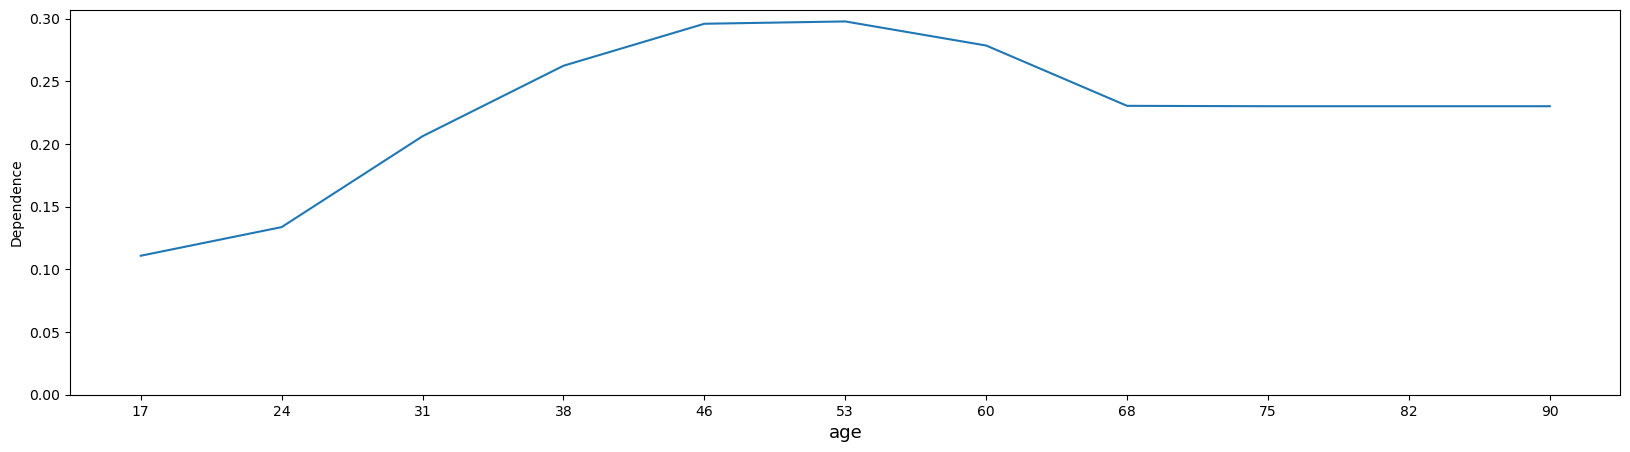

In [11]:
df_education_num = get_pandas_df_from_column(output_pdp, "age_dependence")
plot_dependence_for_numeric(df_education_num, "age")

##### Analysis of Categorical Feature "marital-status"

The model seems to treat "married-cv-spouse" as one category and tend to give a higher average prediction, and all others as a second category with the lower average prediction.

StatementMeta(, e2e2ea89-ac4e-4c13-bd3b-97098186c377, 14, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:117: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


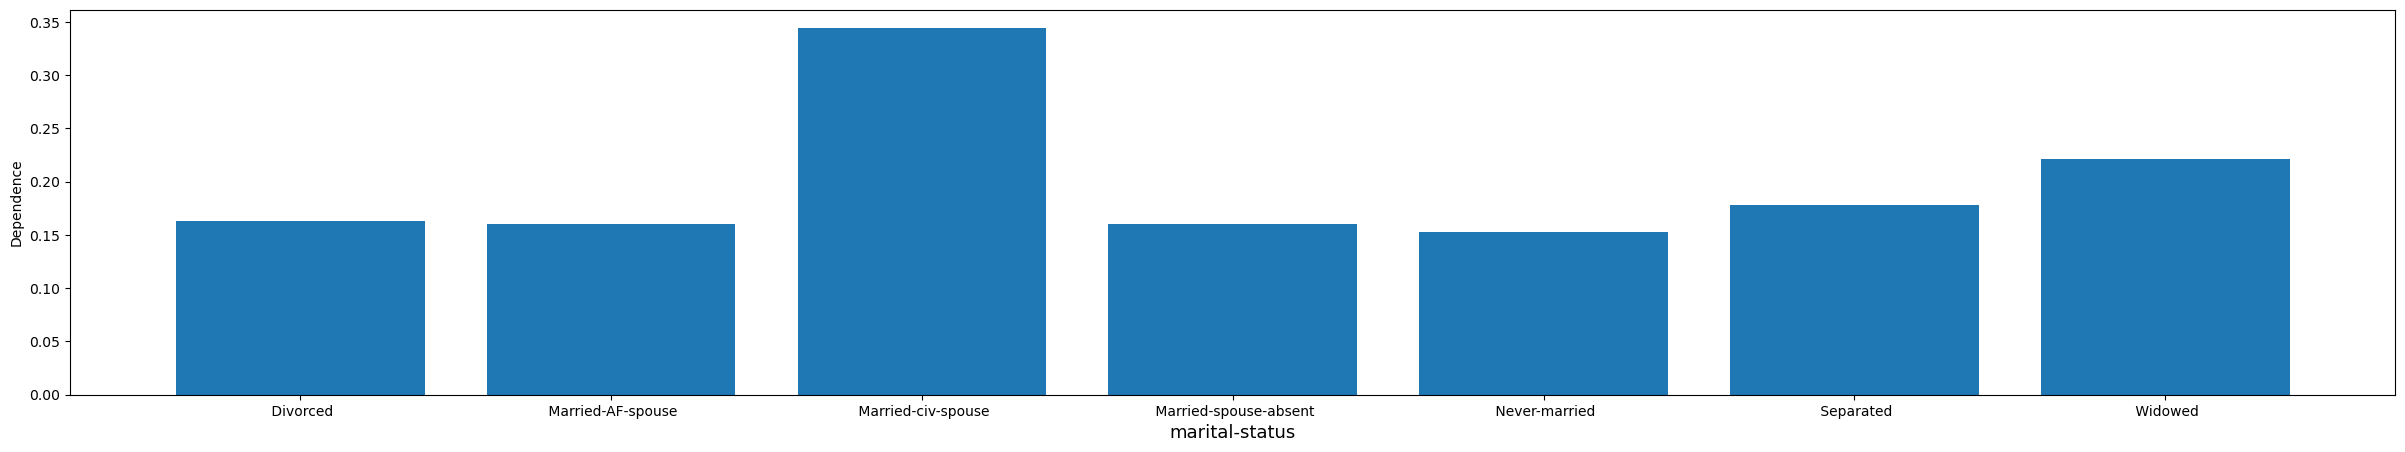

In [12]:
df_occupation = get_pandas_df_from_column(output_pdp, "marital-status_dependence")
plot_dependence_for_categorical(df_occupation, "marital-status", False, figsize=(30, 5))

##### Analysis of Numerical Feature "capital-gain"

When running PDP with its default parameters, it becomes evident that this representation lacks granularity, making it less informative. By default, the numerical feature's range is dynamically calculated based on the data.

StatementMeta(, e2e2ea89-ac4e-4c13-bd3b-97098186c377, 15, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:117: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


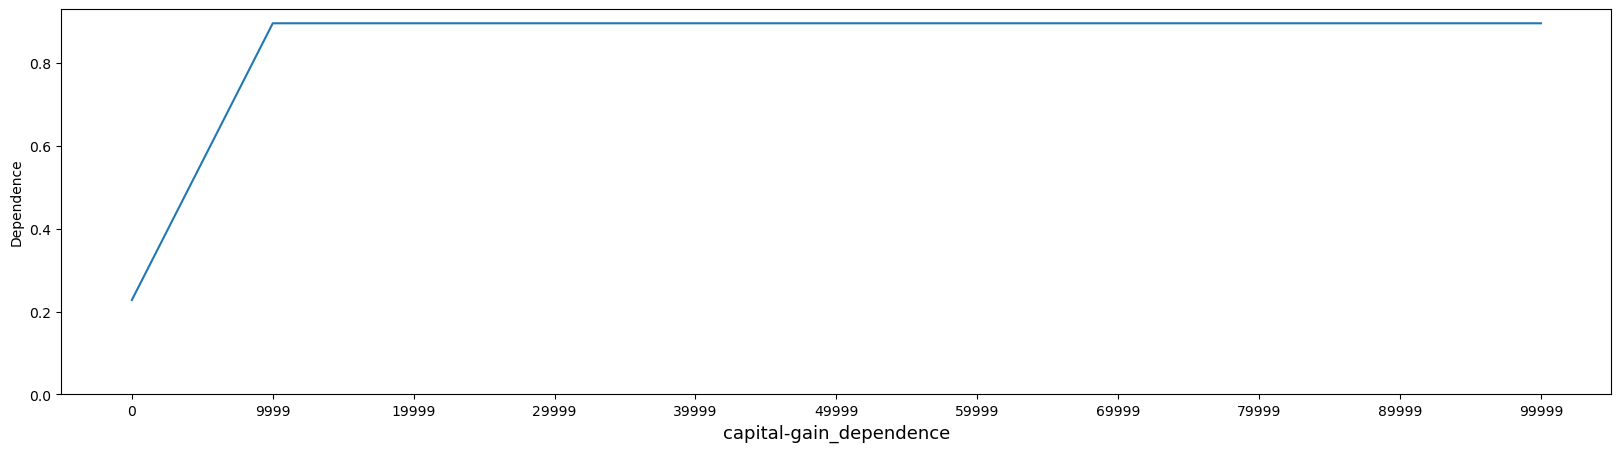

In [13]:
df_education_num = get_pandas_df_from_column(output_pdp, "capital-gain_dependence")
plot_dependence_for_numeric(df_education_num, "capital-gain_dependence")

Setting the `rangeMin = 0` and `rangeMax = 10000` in order to visualize a more granular interpretation for the feature of interest. You can now see more clearly how the model made decisions in a smaller region.

StatementMeta(, e2e2ea89-ac4e-4c13-bd3b-97098186c377, 16, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:117: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


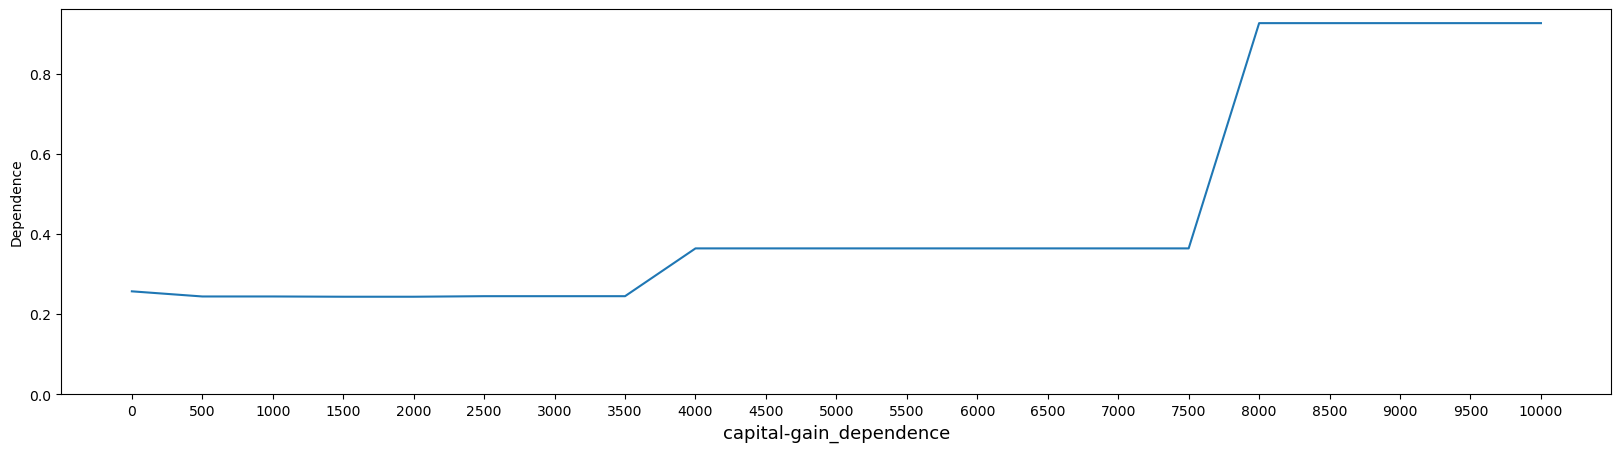

In [14]:
pdp_cap_gain = ICETransformer(
    model=model,
    targetCol="probability",
    kind="average",
    targetClasses=[1],
    numericFeatures=[
        {"name": "capital-gain", "numSplits": 20, "rangeMin": 0.0, "rangeMax": 10000.0}
    ],
    numSamples=50,
)
output_pdp_cap_gain = pdp_cap_gain.transform(df)
df_education_num_gain = get_pandas_df_from_column(
    output_pdp_cap_gain, "capital-gain_dependence"
)
plot_dependence_for_numeric(df_education_num_gain, "capital-gain_dependence")

Based on the demonstrations above, it is clear that you can utilize PDP to illustrate how various features, on average, impact model's predictions. This approach can be valuable for detecting any unexpected or unusual model behavior.

### **PDP-based Feature Importance**

Using PDP, you can also calculate a simple partial dependence-based feature importance measure. When you observe a flat PDP, it suggests that altering the feature doesn't significantly impact predictions. Conversely, when the PDP exhibits more variation, it indicates that the feature holds **greater importance** in influencing the predictions.

Learn more about PDP-based feature importance in [Christoph M's Interpretable ML Book](https://christophm.github.io/interpretable-ml-book/pdp.html#pdp-based-feature-importance).

#### Set up the transformer for PDP-based Feature Importance

To create a plot based on PDP-derived feature importance, you should begin by configuring an instance of `ICETransformer` and set the `kind` parameter to `feature`. Following that, you can use the `transform` function.

The `transform` function will yield a two-column table where the first column contains feature importance values, and the second column contains the corresponding feature names. These rows are sorted in descending order based on their feature importance values.

In [15]:
pdp_based_imp = ICETransformer(
    model=model,
    targetCol="probability",
    kind="feature",
    targetClasses=[1],
    categoricalFeatures=categorical_features,
    numericFeatures=numeric_features,
)

output_pdp_based_imp = pdp_based_imp.transform(df)
display(output_pdp_based_imp)

StatementMeta(, e2e2ea89-ac4e-4c13-bd3b-97098186c377, 17, Finished, Available)

SynapseWidget(Synapse.DataFrame, 5421f0d1-a7d1-4977-865c-d21791b61a49)

In [16]:
# Helper functions for visualization
def plot_pdp_based_imp(df, figsize=(35, 5)):
    values_list = list(df.select("pdpBasedDependence").toPandas()["pdpBasedDependence"])
    names = list(df.select("featureNames").toPandas()["featureNames"])
    dependence_values = []
    for vec in values_list:
        dependence_values.append(vec.toArray()[0])

    fig = plt.figure(figsize=figsize)
    plt.bar(names, dependence_values)

    plt.xlabel("Feature names", size=13)
    plt.ylabel("PDP-based-feature-imporance")
    plt.show()

StatementMeta(, e2e2ea89-ac4e-4c13-bd3b-97098186c377, 18, Finished, Available)

StatementMeta(, e2e2ea89-ac4e-4c13-bd3b-97098186c377, 19, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:117: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


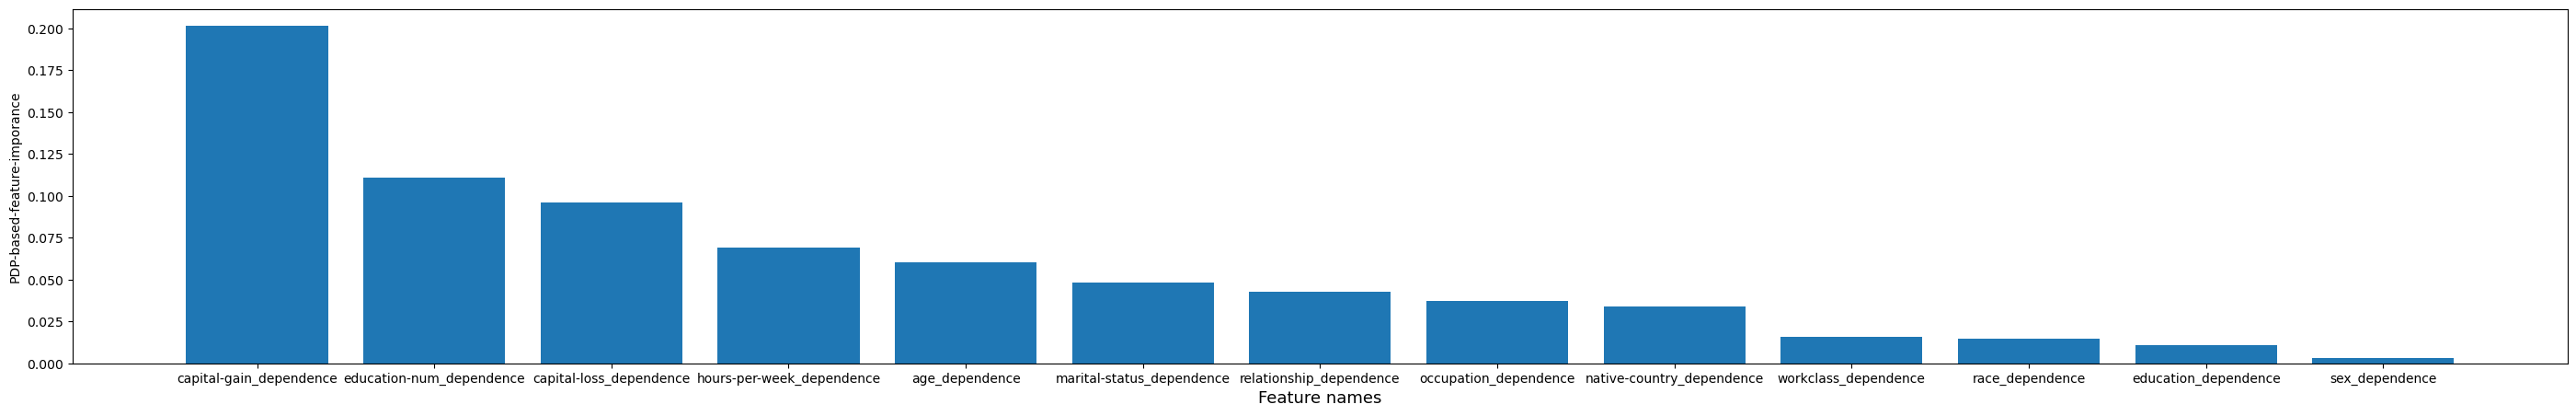

In [17]:
plot_pdp_based_imp(output_pdp_based_imp)

The PDP-derived feature importance analysis reveals that the features `capital-gain` and `education-num` had the highest importance for the model's predictions, while `sex` and `education` had the lowest importance.

### **Individual Conditional Expectation**

ICE plots are a data visualization technique used in machine learning and statistical analysis to gain insights into the behavior of a predictive model.

ICE plots present a distinct line for each individual data instance, and are particularly useful to understand and show how the prediction for that instance changes as the value of a particular feature is altered. Essentially, it offers a detailed view of how the model's predictions vary for each instance when you manipulate a specific feature of interest. This is valuable when you need to closely examine how your model performs for each data point and can help you detect model bias, nonlinearity, and interactions between variables.

Learn more about [ICE plots](https://scikit-learn.org/stable/modules/partial_dependence.html#individual-conditional-expectation-ice-plot).

#### Set up the transformer for ICE

To plot ICE, you need to set up an instance of `ICETransformer` first, set the `kind` parameter to `individual`, and then call the `transform` function.

For the setup, you need to pass the pre-trained model, specify the target column (e.g., `probability` in this case), and pass categorical and numeric feature names. For better visualization, you can set the number of samples to 50.

In [18]:
ice = ICETransformer(
    model=model,
    targetCol="probability",
    targetClasses=[1],
    categoricalFeatures=categorical_features,
    numericFeatures=numeric_features,
    numSamples=50,
)

output = ice.transform(df)

StatementMeta(, e2e2ea89-ac4e-4c13-bd3b-97098186c377, 20, Finished, Available)

#### Visualization of ICE

In the following, you develop helper functions for data visualization of ICE.

In [19]:
# Helper functions for visualization
from math import pi
from collections import defaultdict

# Plot ICE curves for a numeric column 
def plot_ice_numeric(df, col, col_int=True, figsize=(20, 10)):
    dict_values = defaultdict(list)
    col_names = list(df.columns)
    num_instances = df.shape[0]

    instances_y = {}
    i = 0

    for col_name in col_names:
        for i in range(num_instances):
            dict_values[i].append(df[col_name][i].toArray()[0])

    fig = plt.figure(figsize=figsize)
    for i in range(num_instances):
        plt.plot(col_names, dict_values[i], "k")

    plt.xlabel(col, size=13)
    plt.ylabel("Dependence")
    plt.ylim(0.0)

# Plot ICE curves for a categorical column 
def plot_ice_categorical(df, col, col_int=True, figsize=(20, 10)):
    dict_values = defaultdict(list)
    col_names = list(df.columns)
    num_instances = df.shape[0]

    angles = [n / float(df.shape[1]) * 2 * pi for n in range(df.shape[1])]
    angles += angles[:1]

    instances_y = {}
    i = 0

    for col_name in col_names:
        for i in range(num_instances):
            dict_values[i].append(df[col_name][i].toArray()[0])

    fig = plt.figure(figsize=figsize)
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], col_names)

    for i in range(num_instances):
        values = dict_values[i]
        values += values[:1]
        ax.plot(angles, values, "k")
        ax.fill(angles, values, "teal", alpha=0.1)

    plt.xlabel(col, size=13)
    plt.show()

# Overlays ICE curves from o df_ice DataFrame with a PDP curve from df_pdp DataFrame for a specific column
def overlay_ice_with_pdp(df_ice, df_pdp, col, col_int=True, figsize=(20, 5)):
    dict_values = defaultdict(list)
    col_names_ice = list(df_ice.columns)
    num_instances = df_ice.shape[0]

    instances_y = {}
    i = 0

    for col_name in col_names_ice:
        for i in range(num_instances):
            dict_values[i].append(df_ice[col_name][i].toArray()[0])

    fig = plt.figure(figsize=figsize)
    for i in range(num_instances):
        plt.plot(col_names_ice, dict_values[i], "k")

    dict_values_pdp = {}
    col_names = list(df_pdp.columns)

    for col_name in col_names:
        dict_values_pdp[col_name] = df_pdp[col_name][0].toArray()[0]
        marklist = sorted(
            dict_values_pdp.items(), key=lambda x: int(x[0]) if col_int else x[0]
        )
        sortdict = dict(marklist)

    plt.plot(col_names_ice, list(sortdict.values()), "r", linewidth=5)

    plt.xlabel(col, size=13)
    plt.ylabel("Dependence")
    plt.ylim(0.0)
    plt.show()

StatementMeta(, e2e2ea89-ac4e-4c13-bd3b-97098186c377, 21, Finished, Available)

##### Analysis of Numeric Feature "age"

You can superimpose the PDP on the ICE plots. In this graph, the red line represents the PDP plot for the `age` feature, while the black lines represent ICE plots for 50 randomly chosen observations.

This visualization illustrates that all the curves in the ICE plot follow a similar trajectory. This indicates that the PDP (red line) effectively summarizes the relationships between the displayed feature `age` and the model's average predictions of `income`.

StatementMeta(, e2e2ea89-ac4e-4c13-bd3b-97098186c377, 22, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:117: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:117: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


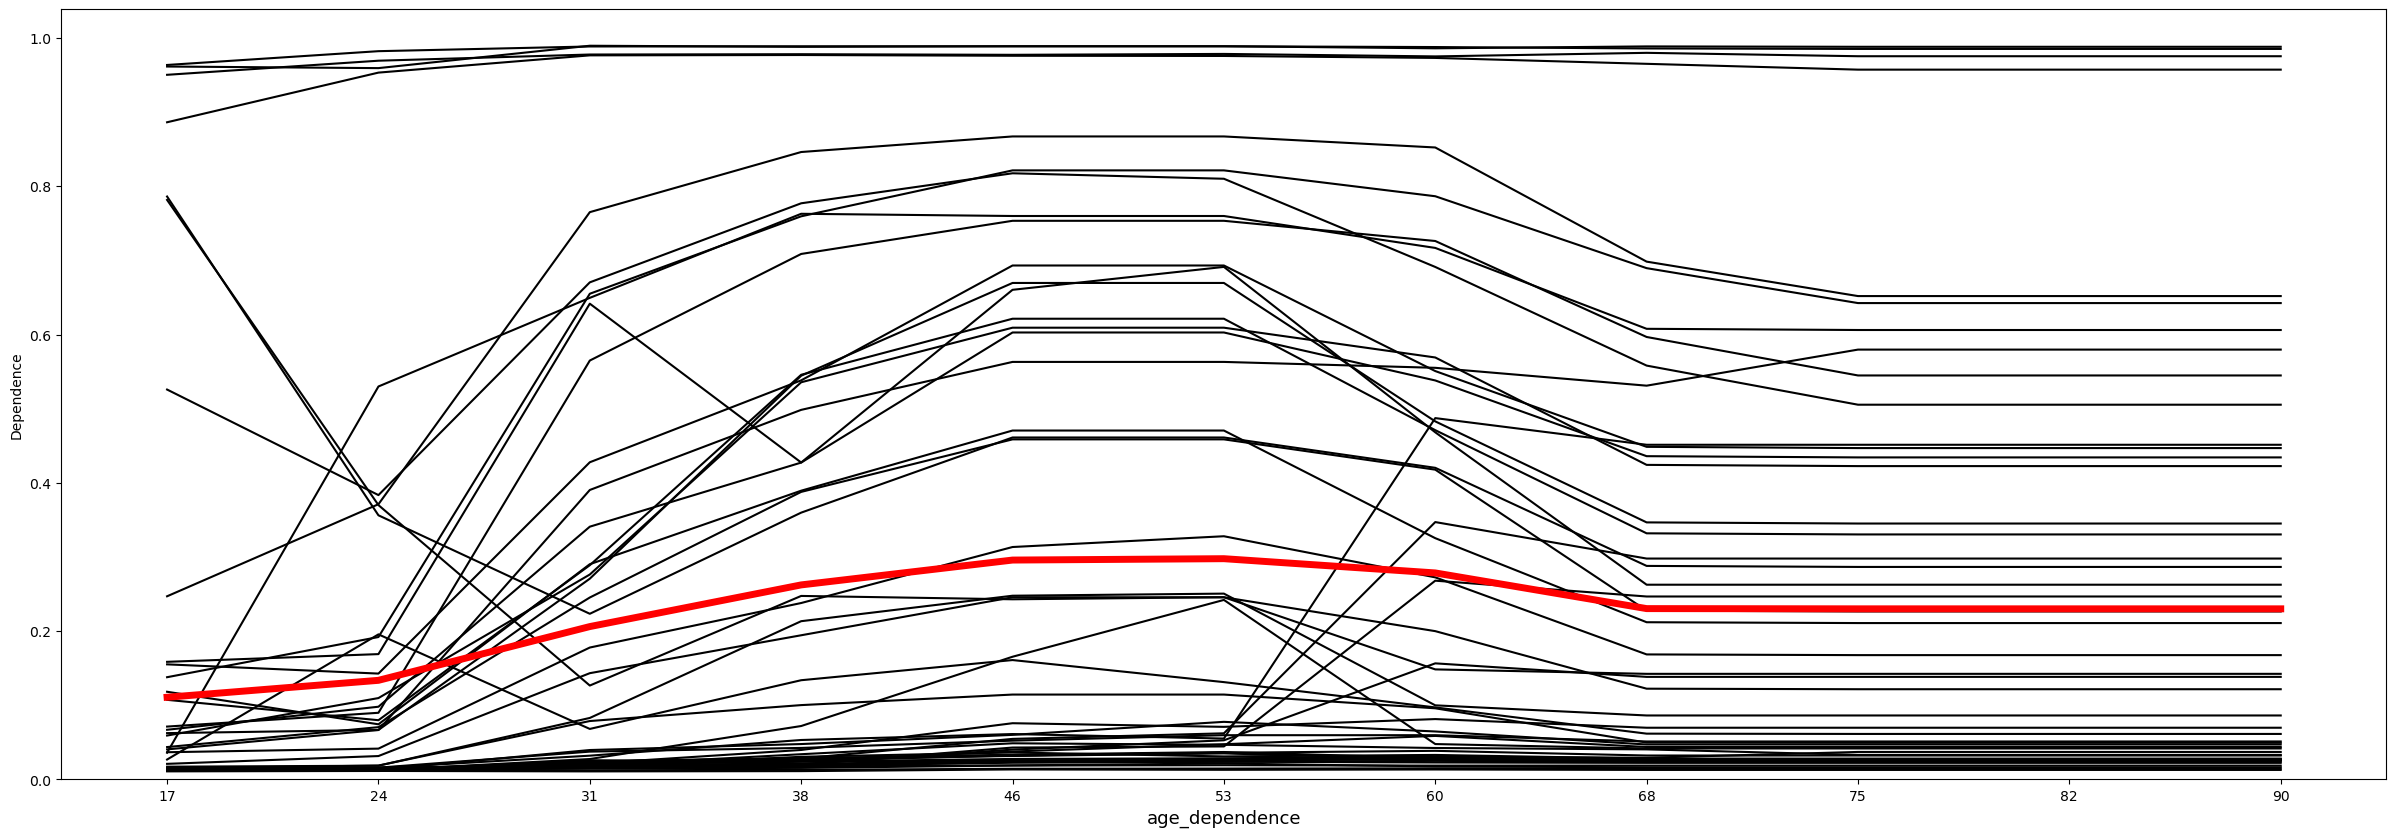

In [20]:
age_df_ice = get_pandas_df_from_column(output, "age_dependence")
age_df_pdp = get_pandas_df_from_column(output_pdp, "age_dependence")

overlay_ice_with_pdp(age_df_ice, age_df_pdp, col="age_dependence", figsize=(30, 10))

##### Analysis of Categorical Feature "occupation"

To visualize categorical features, a star plot is employed:

- The X-axis is represented by a circle divided into equal segments, each representing a feature value.
- The Y-coordinate signifies the dependence values, with each line corresponding to a sample observation.

It's noticeable that the `Farming-fishing` category has the least impact on predictions, as evidenced by values clustering near the lowest probabilities. Conversely, the `Exec-managerial` category appears to have one of the highest impacts on model predictions.

StatementMeta(, e2e2ea89-ac4e-4c13-bd3b-97098186c377, 23, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:117: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


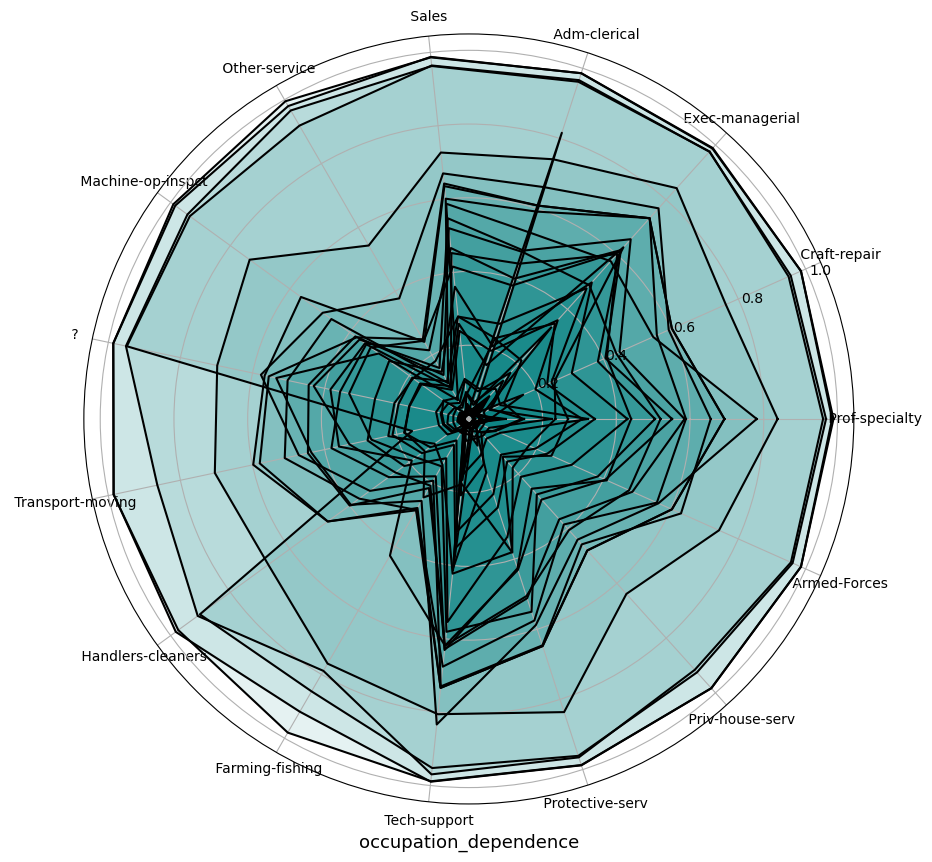

In [21]:
occupation_dep = get_pandas_df_from_column(output, "occupation_dependence")

plot_ice_categorical(occupation_dep, "occupation_dependence", figsize=(30, 10))


From above demonstrations, you can see that ICE plots provide insights into how the model behaves for individual observations. In these plots, each line represents the model's prediction as you change the value of the feature of interest for a specific observation.

## Summary of the learnings

In summary, in this tutorial you have learned how to leverage PDP and ICE plots as two valuable techniques for visualizing and analyzing interactions between a target response and specific input features in order to gain insights into the behavior of your machine learning model.

PDPs offer insights into the average prediction's dependence on varying each feature individually. Conversely, ICE plots reveal how individual samples' predictions are influenced by feature variations. Both methods help in estimating how a model's predictions deviate from a baseline.

Interpretation methods are essential tools in responsible AI practices and these visualizations techniques not only enhance your understanding of the model's predictions, but also facilitate model validation, model debugging and feature engineering, ultimately leading to more robust and interpretable machine learning solutions. They also enhance transparency and provide an additional layer of accountability for model developers when presenting models to users or stakeholders. 

By using the examples demonstrated above, you've learned how to calculate and visualize such plots efficiently, allowing you to comprehend how a classification or regression model generates predictions, identify influential features, and observe how model predictions change with varying feature values.